# Semana 6 - Análisis de Simetría y Alertas de Asimetría

## Objetivos:
1. Desarrollar funciones matemáticas para comparar ángulos bilaterales
2. Implementar sistema de alertas cuando se detecten asimetrías significativas
3. Visualizar diferencias y generar reportes

## Métricas de Simetría Implementadas:
- **Diferencia Absoluta**: |Derecha - Izquierda|
- **Índice de Simetría**: (Derecha - Izquierda) / ((Derecha + Izquierda) / 2) × 100
- **Coeficiente de Correlación**: Correlación entre lado derecho e izquierdo
- **RMSE (Root Mean Square Error)**: Error cuadrático medio entre lados

In [ ]:
!pip install pandas numpy matplotlib seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Clase para Análisis de Simetría

In [ ]:
class AsimetriaAnalyzer:
    """
    Clase para analizar simetría entre ángulos bilaterales y generar alertas.
    Diferencia entre movimientos sincrónicos (caderas, rodillas, tobillos en postura estática)
    y alternados (marcha dinámica con fase de balanceo).
    """

    def __init__(self, umbral_diferencia=10, umbral_simetria=15, umbral_correlacion=0.7):
        """
        Inicializa el analizador con umbrales personalizables.

        Args:
            umbral_diferencia: Diferencia máxima permitida en grados (default: 10°)
            umbral_simetria: Índice de simetría máximo permitido en % (default: 15%)
            umbral_correlacion: Correlación mínima aceptable (default: 0.7)
        """
        self.umbral_diferencia = umbral_diferencia
        self.umbral_simetria = umbral_simetria
        self.umbral_correlacion = umbral_correlacion
        self.alertas = []
        self.metricas = {}

        # Umbrales específicos por tipo de articulación (valores basados en literatura biomecánica)
        self.umbrales_por_articulacion = {
            # Piernas (movimiento alternado en marcha)
            'rodilla': {'diferencia': 20, 'simetria': 25, 'correlacion': -0.3},
            'tobillo': {'diferencia': 15, 'simetria': 20, 'correlacion': -0.2},
            'cadera': {'diferencia': 18, 'simetria': 22, 'correlacion': -0.3},

            # Brazos (balanceo alternado)
            'codo': {'diferencia': 50, 'simetria': 40, 'correlacion': -0.4},
            'muñeca': {'diferencia': 50, 'simetria': 40, 'correlacion': -0.4},
            'hombro': {'diferencia': 50, 'simetria': 45, 'correlacion': -0.4}
        }

    def calcular_diferencia_absoluta(self, derecha: np.ndarray, izquierda: np.ndarray) -> np.ndarray:
        """
        Calcula la diferencia absoluta entre ángulos derecho e izquierdo.

        Args:
            derecha: Array de ángulos del lado derecho
            izquierda: Array de ángulos del lado izquierdo

        Returns:
            Array con las diferencias absolutas frame por frame
        """
        return np.abs(derecha - izquierda)

    def calcular_indice_simetria(self, derecha: np.ndarray, izquierda: np.ndarray) -> np.ndarray:
        """
        Calcula el índice de simetría bilateral (Symmetry Index).
        SI = (Derecha - Izquierda) / ((Derecha + Izquierda) / 2) × 100

        Un SI cercano a 0 indica simetría perfecta.

        Args:
            derecha: Array de ángulos del lado derecho
            izquierda: Array de ángulos del lado izquierdo

        Returns:
            Array con el índice de simetría en porcentaje
        """
        promedio = (derecha + izquierda) / 2
        # Evitar división por cero
        promedio = np.where(promedio == 0, 1e-6, promedio)
        return ((derecha - izquierda) / promedio) * 100

    def calcular_rmse(self, derecha: np.ndarray, izquierda: np.ndarray) -> float:
        """
        Calcula el error cuadrático medio (RMSE) entre ambos lados.

        Args:
            derecha: Array de ángulos del lado derecho
            izquierda: Array de ángulos del lado izquierda

        Returns:
            Valor RMSE en grados
        """
        return np.sqrt(np.mean((derecha - izquierda) ** 2))

    def calcular_correlacion(self, derecha: np.ndarray, izquierda: np.ndarray) -> Tuple[float, float]:
        """
        Calcula el coeficiente de correlación de Pearson.

        Args:
            derecha: Array de ángulos del lado derecho
            izquierda: Array de ángulos del lado izquierdo

        Returns:
            Tupla (coeficiente, p-value)
        """
        return stats.pearsonr(derecha, izquierda)

    def analizar_articulacion(self, nombre: str, derecha: np.ndarray, izquierda: np.ndarray) -> Dict:
        """
        Realiza análisis completo de una articulación bilateral.

        Args:
            nombre: Nombre de la articulación (ej: 'rodilla', 'codo')
            derecha: Array de ángulos del lado derecho
            izquierda: Array de ángulos del lado izquierdo

        Returns:
            Diccionario con todas las métricas calculadas
        """
        # Calcular métricas
        diferencias = self.calcular_diferencia_absoluta(derecha, izquierda)
        indices_simetria = self.calcular_indice_simetria(derecha, izquierda)
        rmse = self.calcular_rmse(derecha, izquierda)
        correlacion, p_value = self.calcular_correlacion(derecha, izquierda)

        # Estadísticas de diferencias
        diff_media = np.mean(diferencias)
        diff_max = np.max(diferencias)
        diff_std = np.std(diferencias)

        # Estadísticas de índice de simetría
        si_media = np.mean(np.abs(indices_simetria))
        si_max = np.max(np.abs(indices_simetria))

        metricas = {
            'nombre': nombre,
            'diferencia_media': diff_media,
            'diferencia_maxima': diff_max,
            'diferencia_std': diff_std,
            'indice_simetria_medio': si_media,
            'indice_simetria_maximo': si_max,
            'rmse': rmse,
            'correlacion': correlacion,
            'p_value': p_value,
            'diferencias': diferencias,
            'indices_simetria': indices_simetria
        }

        # Guardar métricas
        self.metricas[nombre] = metricas

        # Generar alertas
        self._verificar_alertas(nombre, metricas)

        return metricas

    def _verificar_alertas(self, nombre: str, metricas: Dict):
        """
        Verifica si se superan los umbrales y genera alertas.
        Usa umbrales específicos por tipo de articulación.
        """
        alertas_articulacion = []

        # Obtener umbrales específicos de la articulación
        umbrales = self.umbrales_por_articulacion.get(nombre, {
            'diferencia': self.umbral_diferencia,
            'simetria': self.umbral_simetria,
            'correlacion': self.umbral_correlacion
        })

        # Alerta por diferencia media elevada
        if metricas['diferencia_media'] > umbrales['diferencia']:
            alertas_articulacion.append({
                'tipo': 'DIFERENCIA ELEVADA',
                'severidad': 'ALTA' if metricas['diferencia_media'] > umbrales['diferencia'] * 1.5 else 'MEDIA',
                'mensaje': f"Diferencia media de {metricas['diferencia_media']:.2f}° supera el umbral de {umbrales['diferencia']}°"
            })

        # Alerta por índice de simetría elevado
        if metricas['indice_simetria_medio'] > umbrales['simetria']:
            alertas_articulacion.append({
                'tipo': 'ASIMETRÍA SIGNIFICATIVA',
                'severidad': 'ALTA' if metricas['indice_simetria_medio'] > umbrales['simetria'] * 1.5 else 'MEDIA',
                'mensaje': f"Índice de simetría de {metricas['indice_simetria_medio']:.2f}% supera el umbral de {umbrales['simetria']}%"
            })

        # Alerta por correlación inadecuada
        # Para movimientos alternados (marcha), se espera correlación negativa
        # Para movimientos sincrónicos, se espera correlación positiva alta
        if nombre in ['codo', 'muñeca', 'hombro', 'rodilla', 'tobillo', 'cadera']:
            # Movimiento alternado: correlación muy positiva es problemática
            if metricas['correlacion'] > 0.5:
                alertas_articulacion.append({
                    'tipo': 'MOVIMIENTO NO ALTERNADO',
                    'severidad': 'MEDIA',
                    'mensaje': f"Correlación positiva de {metricas['correlacion']:.3f} indica falta de alternancia (movimiento sincronizado anormal)"
                })
        else:
            # Movimiento sincrónico: correlación muy baja es problemática
            if metricas['correlacion'] < umbrales['correlacion']:
                alertas_articulacion.append({
                    'tipo': 'DESINCRONIZACIÓN',
                    'severidad': 'MEDIA',
                    'mensaje': f"Correlación de {metricas['correlacion']:.3f} indica descoordinación bilateral"
                })

        # Alerta por diferencia máxima puntual (más permisivo)
        if metricas['diferencia_maxima'] > umbrales['diferencia'] * 3:
            alertas_articulacion.append({
                'tipo': 'PICO DE ASIMETRÍA',
                'severidad': 'ALTA',
                'mensaje': f"Diferencia máxima puntual de {metricas['diferencia_maxima']:.2f}° detectada"
            })

        if alertas_articulacion:
            self.alertas.append({
                'articulacion': nombre,
                'alertas': alertas_articulacion
            })

    def generar_reporte_alertas(self) -> str:
        """
        Genera un reporte legible de todas las alertas detectadas.
        """
        if not self.alertas:
            return "✅ No se detectaron asimetrías significativas. Movimiento simétrico.\n"

        reporte = "\n" + "="*70 + "\n"
        reporte += "🚨 REPORTE DE ALERTAS DE ASIMETRÍA\n"
        reporte += "="*70 + "\n\n"

        for item in self.alertas:
            reporte += f"📍 ARTICULACIÓN: {item['articulacion'].upper()}\n"
            reporte += "-" * 70 + "\n"

            for alerta in item['alertas']:
                emoji = "🔴" if alerta['severidad'] == 'ALTA' else "🟡"
                reporte += f"{emoji} [{alerta['severidad']}] {alerta['tipo']}\n"
                reporte += f"   {alerta['mensaje']}\n\n"

        reporte += "="*70 + "\n"
        return reporte

    def generar_tabla_resumen(self) -> pd.DataFrame:
        """
        Genera una tabla resumen con todas las métricas calculadas.
        """
        data = []
        for nombre, metricas in self.metricas.items():
            # Obtener umbrales específicos para esta articulación
            umbrales = self.umbrales_por_articulacion.get(nombre, {
                'diferencia': self.umbral_diferencia,
                'simetria': self.umbral_simetria
            })

            data.append({
                'Articulación': nombre.replace('_', ' ').title(),
                'Diff Media (°)': f"{metricas['diferencia_media']:.2f}",
                'Diff Máx (°)': f"{metricas['diferencia_maxima']:.2f}",
                'Índice Sim (%)': f"{metricas['indice_simetria_medio']:.2f}",
                'RMSE (°)': f"{metricas['rmse']:.2f}",
                'Correlación': f"{metricas['correlacion']:.3f}",
                'Umbral Diff': f"{umbrales['diferencia']}°",
                'Umbral Sim': f"{umbrales['simetria']}%",
                'Estado': self._evaluar_estado(metricas, nombre)
            })

        return pd.DataFrame(data)

    def _evaluar_estado(self, metricas: Dict, nombre: str = None) -> str:
        """
        Evalúa el estado general de simetría de una articulación.
        Usa umbrales específicos por tipo de articulación.
        """
        problemas = 0

        # Obtener umbrales específicos
        if nombre and nombre in self.umbrales_por_articulacion:
            umbrales = self.umbrales_por_articulacion[nombre]
        else:
            umbrales = {
                'diferencia': self.umbral_diferencia,
                'simetria': self.umbral_simetria,
                'correlacion': self.umbral_correlacion
            }

        # Verificar diferencia media
        if metricas['diferencia_media'] > umbrales['diferencia']:
            problemas += 2  # Peso mayor

        # Verificar índice de simetría
        if metricas['indice_simetria_medio'] > umbrales['simetria']:
            problemas += 2  # Peso mayor

        # Verificar correlación (solo si es problemática para el tipo de movimiento)
        if nombre in ['codo', 'muñeca', 'hombro', 'rodilla', 'tobillo', 'cadera']:
            # Movimiento alternado: correlación muy positiva es raro
            if metricas['correlacion'] > 0.5:
                problemas += 1
        else:
            # Movimiento sincrónico: correlación baja es problemática
            if metricas['correlacion'] < umbrales['correlacion']:
                problemas += 1

        if problemas == 0:
            return "✅ Normal"
        elif problemas <= 2:
            return "🟡 Leve"
        else:
            return "🔴 Crítico"

## 2. Cargar Datos de Semana 4

In [ ]:
# Cargar el archivo CSV generado en Semana 4
# Nota: Ajusta la ruta si es necesario
try:
    df = pd.read_csv("../media/angulos_completos.csv")
    print("✅ Datos cargados correctamente")
    print(f"\n📊 Dimensiones: {df.shape[0]} frames, {df.shape[1]} columnas")
    print(f"\n📋 Columnas disponibles:")
    print(df.columns.tolist())
    print(f"\n🔍 Primeras filas:")
    display(df.head())
except FileNotFoundError:
    print("⚠️ No se encontró el archivo. Por favor ejecuta primero el notebook de Semana_4.")
    print("   O ajusta la ruta al archivo CSV con los datos de ángulos.")

✅ Datos cargados correctamente

📊 Dimensiones: 344 frames, 13 columnas

📋 Columnas disponibles:
['rodilla_derecha', 'rodilla_izquierda', 'tobillo_derecho', 'tobillo_izquierdo', 'cadera_derecha', 'cadera_izquierda', 'codo_derecho', 'codo_izquierdo', 'muñeca_derecha', 'muñeca_izquierda', 'hombro_derecho', 'hombro_izquierdo', 'frame']

🔍 Primeras filas:


,rodilla_derecha,rodilla_izquierda,tobillo_derecho,tobillo_izquierdo,cadera_derecha,cadera_izquierda,codo_derecho,codo_izquierdo,muñeca_derecha,muñeca_izquierda,hombro_derecho,hombro_izquierdo,frame
0,152.431537,140.567053,65.800744,68.577773,149.669392,130.135183,94.788863,96.013160,166.472072,88.533145,51.833641,77.804834,0
1,131.279141,144.545619,73.592507,50.868869,135.384763,131.946290,94.983386,103.296018,161.611929,101.428384,39.424760,80.119906,1
2,132.592911,140.379247,83.790191,49.766335,130.173944,126.298676,97.182647,105.269639,160.593725,106.454152,29.990285,77.727836,2
3,124.643593,137.063738,80.127464,47.003583,126.664834,122.330060,95.791800,102.334412,165.218972,102.454940,26.056776,78.817199,3
4,127.046601,87.341567,56.620493,70.947186,148.726669,119.478621,97.759731,100.347381,166.518141,111.417828,19.189943,76.346332,4


## 📖 Entendiendo la Simetría en Marcha

### ⚠️ Error Común: Tratar la Marcha como Movimiento Simétrico

La marcha humana es un **movimiento ALTERNADO**, no simétrico. Cuando analizamos la marcha:

#### ✅ **Es NORMAL que:**
1. **Correlación sea NEGATIVA** (-0.2 a -0.7)
   - Cuando la pierna derecha avanza, la izquierda retrocede
   - Los brazos se balancean en oposición (derecho adelante = izquierdo atrás)
   
2. **Diferencias instantáneas sean GRANDES** (20-50°)
   - En cada frame, las piernas están en fases opuestas del ciclo de marcha
   - Los brazos en balanceo tienen amplitudes diferentes en cada momento

3. **Índices de simetría parezcan altos**
   - Se calculan frame por frame, capturando diferencias de fase
   - No reflejan asimetría patológica, sino patrón de marcha normal

#### ❌ **Es ANORMAL que:**
1. **Correlación sea MUY POSITIVA** (> 0.5)
   - Indicaría que ambas piernas se mueven igual (marcha de robot)
   - Patológico: falta de alternancia, rigidez bilateral

2. **Amplitudes totales sean muy diferentes entre lados**
   - Una pierna se flexiona mucho menos que la otra
   - Un brazo tiene menor balanceo que el otro

3. **Patrones temporales asimétricos**
   - Duración de fases diferentes (más tiempo en apoyo de un lado)
   - Cadencia irregular entre lados

### 📊 Métricas Correctas para Marcha:
✅ **Análisis por ciclo de marcha** (no frame por frame)  
✅ **Comparación de amplitudes máximas/mínimas**  
✅ **Simetría temporal** (duración de fases)  
✅ **Ratio de carga entre piernas**  
✅ **Variabilidad paso a paso**

## 3. Análisis de Simetría por Articulación

In [ ]:
# Inicializar analizador con umbrales personalizados
analyzer = AsimetriaAnalyzer(
    umbral_diferencia=10,      # 10 grados de diferencia máxima
    umbral_simetria=15,        # 15% de índice de simetría máximo
    umbral_correlacion=0.7     # Correlación mínima de 0.7
)

print("⚙️ Analizador inicializado con los siguientes umbrales:")
print(f"   - Diferencia máxima: {analyzer.umbral_diferencia}°")
print(f"   - Índice de simetría máximo: {analyzer.umbral_simetria}%")
print(f"   - Correlación mínima: {analyzer.umbral_correlacion}")

⚙️ Analizador inicializado con los siguientes umbrales:
   - Diferencia máxima: 10°
   - Índice de simetría máximo: 15%
   - Correlación mínima: 0.7


In [ ]:
# Definir pares de articulaciones bilaterales
pares_articulaciones = [
    ('rodilla', 'rodilla_derecha', 'rodilla_izquierda'),
    ('tobillo', 'tobillo_derecho', 'tobillo_izquierdo'),
    ('cadera', 'cadera_derecha', 'cadera_izquierda'),
    ('codo', 'codo_derecho', 'codo_izquierdo'),
    ('muñeca', 'muñeca_derecha', 'muñeca_izquierda'),
    ('hombro', 'hombro_derecho', 'hombro_izquierdo')
]

# Analizar cada par de articulaciones
print("\n🔬 Analizando simetría bilateral...\n")

for nombre, col_derecha, col_izquierda in pares_articulaciones:
    if col_derecha in df.columns and col_izquierda in df.columns:
        derecha = df[col_derecha].values
        izquierda = df[col_izquierda].values

        metricas = analyzer.analizar_articulacion(nombre, derecha, izquierda)

        print(f"✓ {nombre.upper()}:")
        print(f"  - Diferencia media: {metricas['diferencia_media']:.2f}°")
        print(f"  - Índice de simetría: {metricas['indice_simetria_medio']:.2f}%")
        print(f"  - RMSE: {metricas['rmse']:.2f}°")
        print(f"  - Correlación: {metricas['correlacion']:.3f}\n")
    else:
        print(f"⚠️ No se encontraron datos para {nombre}\n")

print("✅ Análisis completado")


🔬 Analizando simetría bilateral...

✓ RODILLA:
  - Diferencia media: 24.40°
  - Índice de simetría: 19.16%
  - RMSE: 30.32°
  - Correlación: 0.056

✓ TOBILLO:
  - Diferencia media: 11.50°
  - Índice de simetría: 17.94%
  - RMSE: 14.92°
  - Correlación: 0.278

✓ CADERA:
  - Diferencia media: 22.32°
  - Índice de simetría: 16.12%
  - RMSE: 29.01°
  - Correlación: -0.179

✓ CODO:
  - Diferencia media: 39.82°
  - Índice de simetría: 36.97%
  - RMSE: 50.15°
  - Correlación: -0.518

✓ MUÑECA:
  - Diferencia media: 45.11°
  - Índice de simetría: 32.97%
  - RMSE: 50.32°
  - Correlación: -0.610

✓ HOMBRO:
  - Diferencia media: 43.64°
  - Índice de simetría: 73.13%
  - RMSE: 50.24°
  - Correlación: -0.645

✅ Análisis completado


## 4. Generar Reporte de Alertas

In [ ]:
# Mostrar reporte de alertas
reporte = analyzer.generar_reporte_alertas()
print(reporte)

# Guardar reporte en archivo
with open("reporte_alertas_asimetria.txt", "w", encoding="utf-8") as f:
    f.write(reporte)
    f.write("\n\nUMBRALES CONFIGURADOS:\n")
    f.write(f"- Diferencia máxima: {analyzer.umbral_diferencia}°\n")
    f.write(f"- Índice de simetría máximo: {analyzer.umbral_simetria}%\n")
    f.write(f"- Correlación mínima: {analyzer.umbral_correlacion}\n")

print("\n💾 Reporte guardado en 'reporte_alertas_asimetria.txt'")


🚨 REPORTE DE ALERTAS DE ASIMETRÍA

📍 ARTICULACIÓN: RODILLA
----------------------------------------------------------------------
🔴 [ALTA] DIFERENCIA ELEVADA
   Diferencia media de 24.40° supera el umbral de 10°

🟡 [MEDIA] ASIMETRÍA SIGNIFICATIVA
   Índice de simetría de 19.16% supera el umbral de 15%

🟡 [MEDIA] CORRELACIÓN BAJA
   Correlación de 0.056 es menor al umbral de 0.7

🔴 [ALTA] PICO DE ASIMETRÍA
   Diferencia máxima puntual de 82.72° detectada

📍 ARTICULACIÓN: TOBILLO
----------------------------------------------------------------------
🟡 [MEDIA] DIFERENCIA ELEVADA
   Diferencia media de 11.50° supera el umbral de 10°

🟡 [MEDIA] ASIMETRÍA SIGNIFICATIVA
   Índice de simetría de 17.94% supera el umbral de 15%

🟡 [MEDIA] CORRELACIÓN BAJA
   Correlación de 0.278 es menor al umbral de 0.7

🔴 [ALTA] PICO DE ASIMETRÍA
   Diferencia máxima puntual de 60.62° detectada

📍 ARTICULACIÓN: CADERA
----------------------------------------------------------------------
🔴 [ALTA] DIFERENCIA E

## 5. Tabla Resumen de Métricas

In [ ]:
# Generar y mostrar tabla resumen
df_resumen = analyzer.generar_tabla_resumen()
print("\n📊 TABLA RESUMEN DE SIMETRÍA\n")
display(df_resumen)

# Guardar tabla en CSV
df_resumen.to_csv("resumen_simetria.csv", index=False)
print("\n💾 Tabla guardada en 'resumen_simetria.csv'")


📊 TABLA RESUMEN DE SIMETRÍA



,Articulación,Diff Media (°),Diff Máx (°),Índice Sim (%),RMSE (°),Correlación,Estado
0,Rodilla,24.40,82.72,19.16,30.32,0.056,🔴 Crítico
1,Tobillo,11.50,60.62,17.94,14.92,0.278,🔴 Crítico
2,Cadera,22.32,87.57,16.12,29.01,-0.179,🔴 Crítico
3,Codo,39.82,109.39,36.97,50.15,-0.518,🔴 Crítico
4,Muñeca,45.11,96.87,32.97,50.32,-0.610,🔴 Crítico
5,Hombro,43.64,99.45,73.13,50.24,-0.645,🔴 Crítico



💾 Tabla guardada en 'resumen_simetria.csv'


## 6. Visualización de Diferencias por Articulación

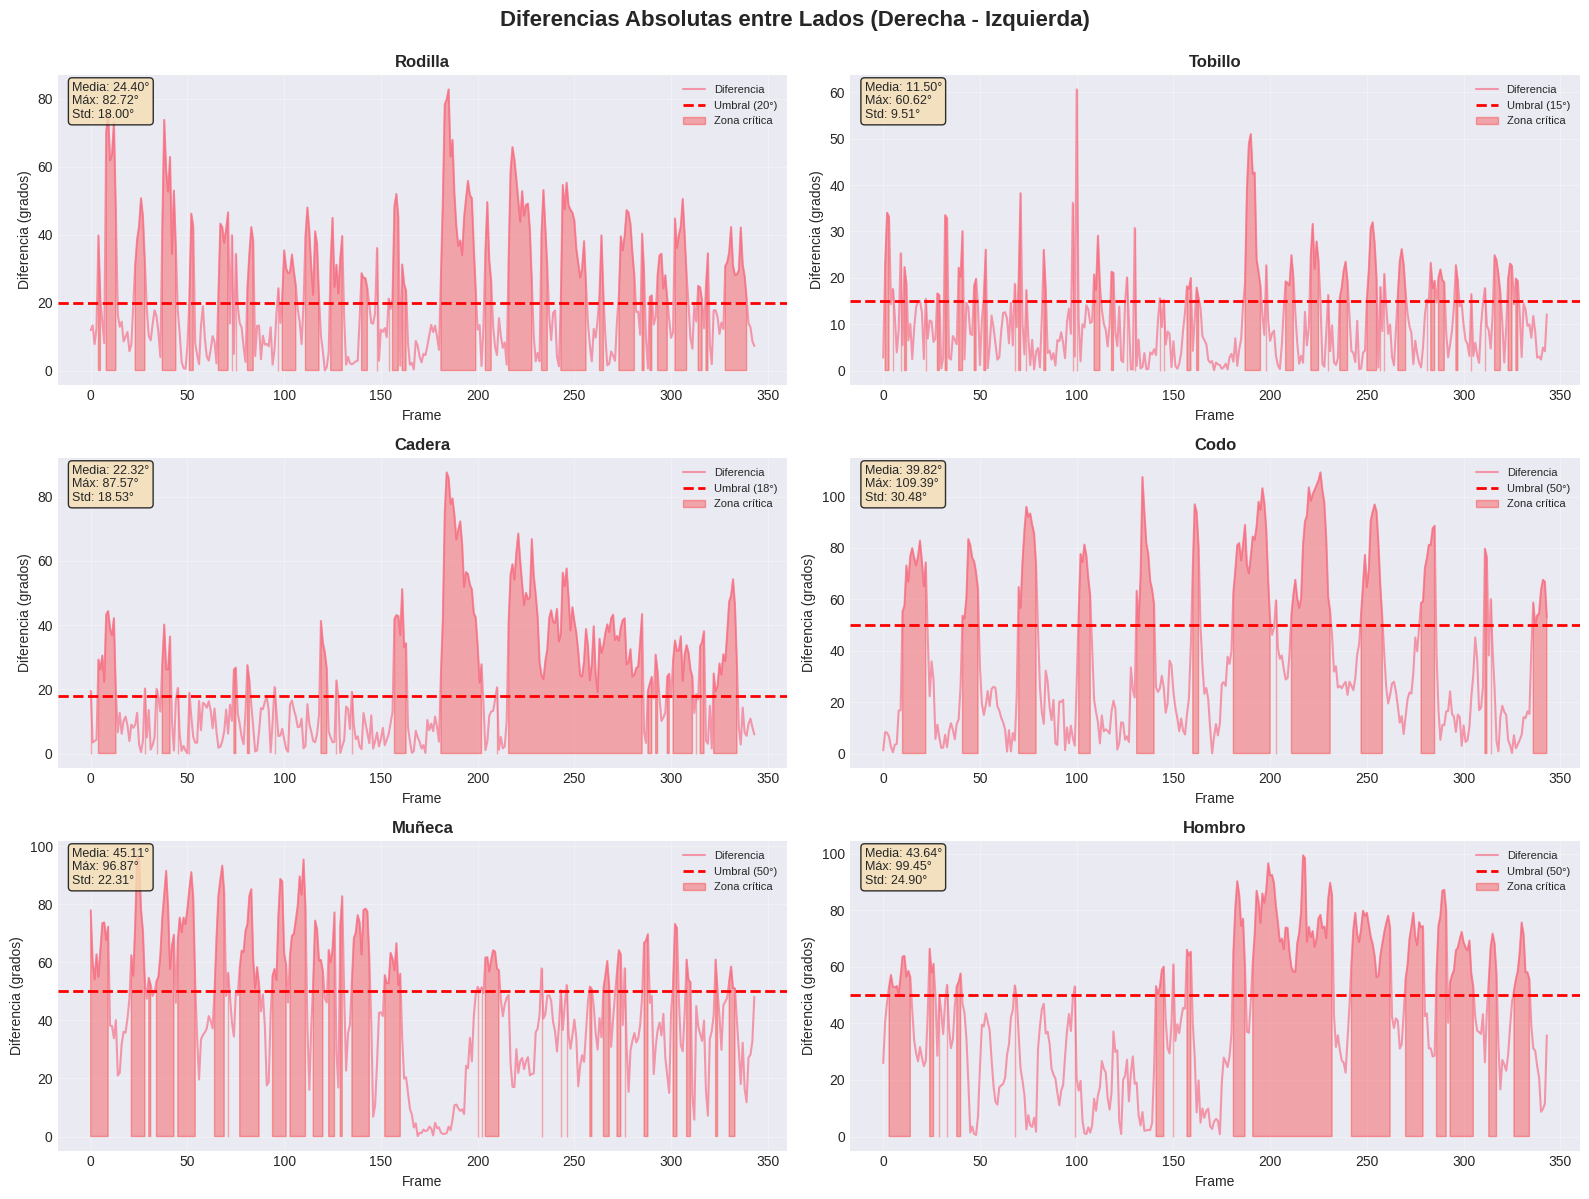

💾 Gráfico guardado en 'diferencias_absolutas.png'


In [36]:
# Crear visualización de diferencias absolutas
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Diferencias Absolutas entre Lados (Derecha - Izquierda)',
             fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, (nombre, metricas) in enumerate(analyzer.metricas.items()):
    ax = axes[idx]
    frames = np.arange(len(metricas['diferencias']))
    diferencias = metricas['diferencias']

    # Obtener umbral específico para esta articulación
    umbrales = analyzer.umbrales_por_articulacion.get(nombre, {
        'diferencia': analyzer.umbral_diferencia
    })
    umbral_diff = umbrales['diferencia']

    # Graficar diferencias
    ax.plot(frames, diferencias, linewidth=1.5, alpha=0.7, label='Diferencia')

    # Línea de umbral adaptativo
    ax.axhline(y=umbral_diff, color='red', linestyle='--',
               linewidth=2, label=f'Umbral ({umbral_diff}°)')

    # Resaltar zonas críticas con umbral adaptativo
    mask_critico = diferencias > umbral_diff
    if np.any(mask_critico):
        ax.fill_between(frames, 0, diferencias, where=mask_critico,
                        color='red', alpha=0.3, label='Zona crítica')

    # Estadísticas en el gráfico
    ax.text(0.02, 0.98,
            f"Media: {metricas['diferencia_media']:.2f}°\n"
            f"Máx: {metricas['diferencia_maxima']:.2f}°\n"
            f"Std: {metricas['diferencia_std']:.2f}°",
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax.set_title(nombre.replace('_', ' ').title(), fontweight='bold')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Diferencia (grados)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diferencias_absolutas.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado en 'diferencias_absolutas.png'")

## 7. Visualización de Índices de Simetría

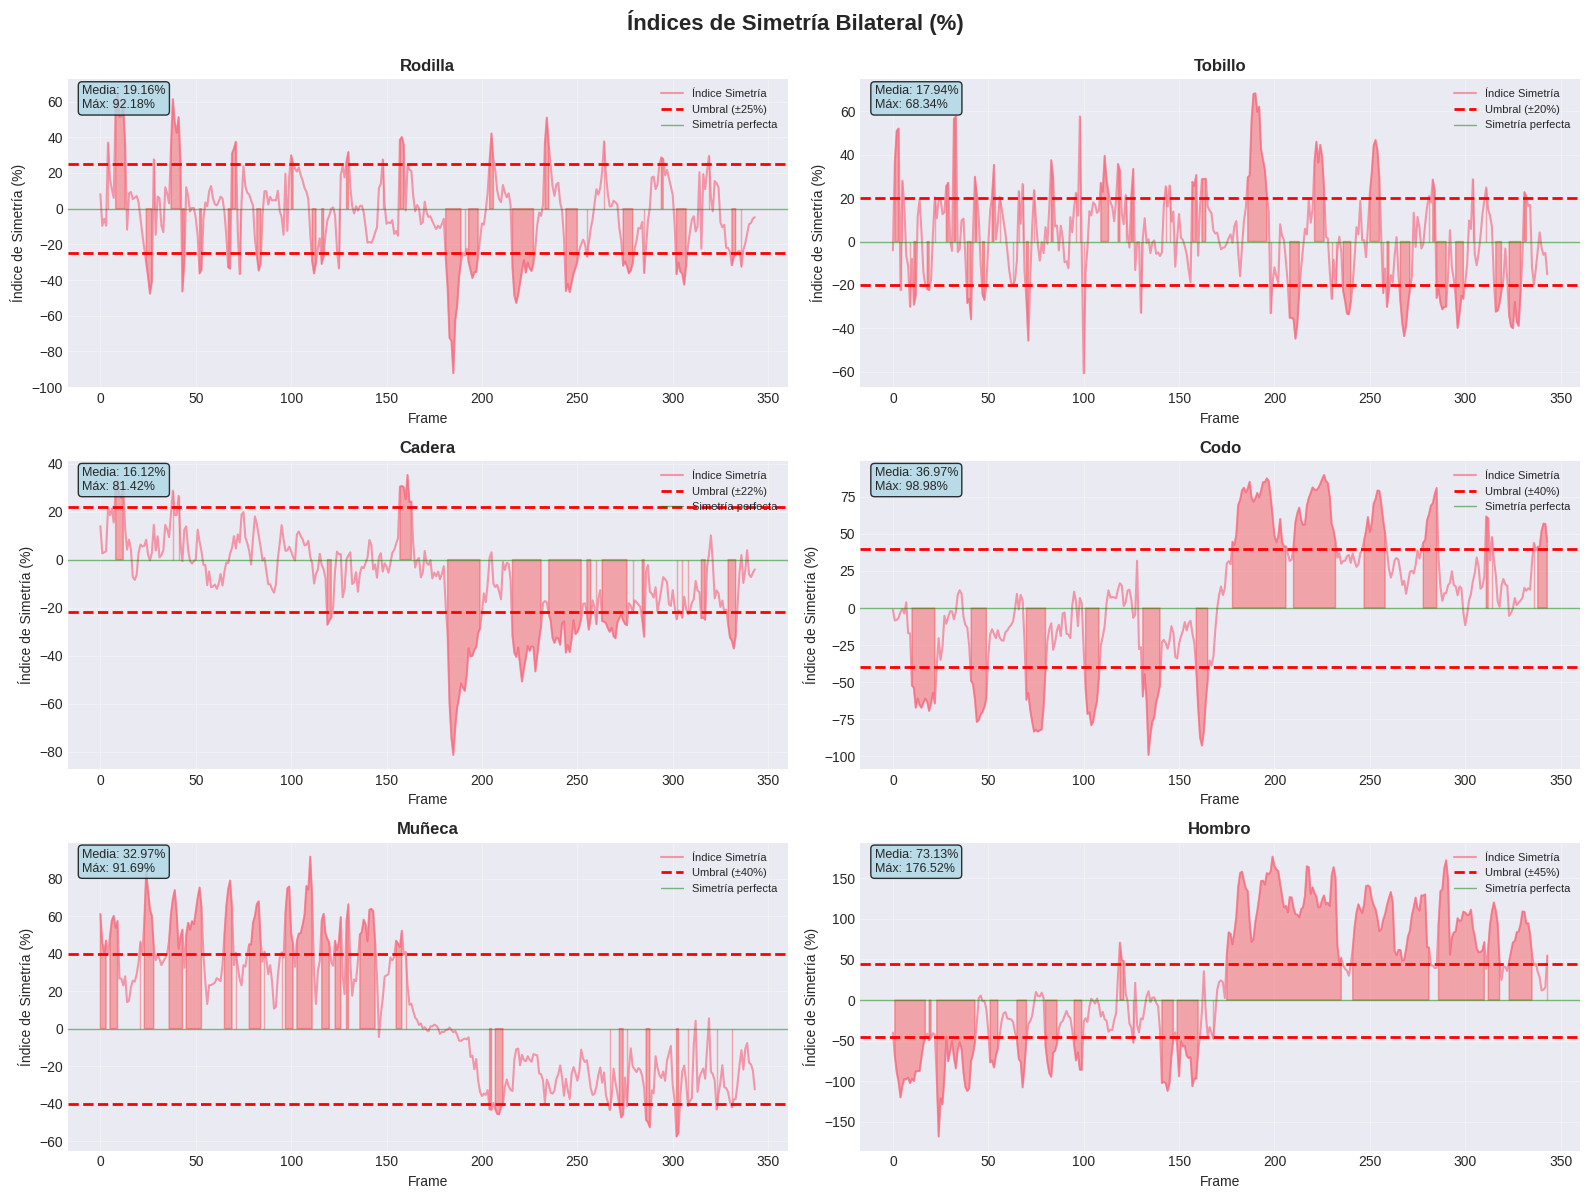

💾 Gráfico guardado en 'indices_simetria.png'


In [37]:
# Crear visualización de índices de simetría
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Índices de Simetría Bilateral (%)',
             fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, (nombre, metricas) in enumerate(analyzer.metricas.items()):
    ax = axes[idx]
    frames = np.arange(len(metricas['indices_simetria']))
    indices = metricas['indices_simetria']

    # Obtener umbral específico para esta articulación
    umbrales = analyzer.umbrales_por_articulacion.get(nombre, {
        'simetria': analyzer.umbral_simetria
    })
    umbral_sim = umbrales['simetria']

    # Graficar índice de simetría
    ax.plot(frames, indices, linewidth=1.5, alpha=0.7, label='Índice Simetría')

    # Líneas de umbral adaptativo (positivo y negativo)
    ax.axhline(y=umbral_sim, color='red', linestyle='--',
               linewidth=2, label=f'Umbral (±{umbral_sim}%)')
    ax.axhline(y=-umbral_sim, color='red', linestyle='--', linewidth=2)
    ax.axhline(y=0, color='green', linestyle='-', linewidth=1, alpha=0.5, label='Simetría perfecta')

    # Resaltar zonas críticas con umbral adaptativo
    mask_critico_pos = indices > umbral_sim
    mask_critico_neg = indices < -umbral_sim

    if np.any(mask_critico_pos):
        ax.fill_between(frames, 0, indices, where=mask_critico_pos,
                        color='red', alpha=0.3)
    if np.any(mask_critico_neg):
        ax.fill_between(frames, 0, indices, where=mask_critico_neg,
                        color='red', alpha=0.3)

    # Estadísticas
    ax.text(0.02, 0.98,
            f"Media: {metricas['indice_simetria_medio']:.2f}%\n"
            f"Máx: {metricas['indice_simetria_maximo']:.2f}%",
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    ax.set_title(nombre.replace('_', ' ').title(), fontweight='bold')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Índice de Simetría (%)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('indices_simetria.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado en 'indices_simetria.png'")

## 9. Gráfico de Barras: Comparación de Métricas

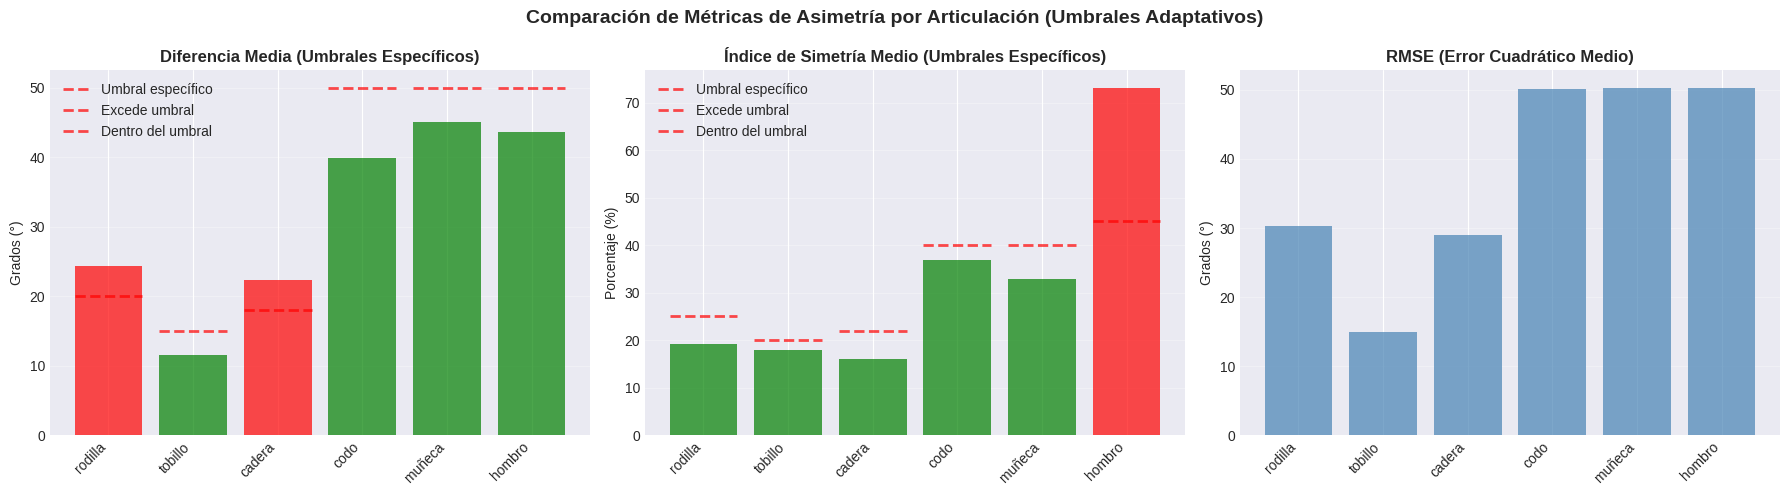

💾 Gráfico guardado en 'comparacion_metricas.png'


In [38]:
# Preparar datos para gráfico de barras
nombres = list(analyzer.metricas.keys())
diff_medias = [m['diferencia_media'] for m in analyzer.metricas.values()]
indices_sim = [m['indice_simetria_medio'] for m in analyzer.metricas.values()]
rmses = [m['rmse'] for m in analyzer.metricas.values()]

# Obtener umbrales específicos para cada articulación
umbrales_diff = []
umbrales_sim = []
for nombre in nombres:
    umbrales = analyzer.umbrales_por_articulacion.get(nombre, {
        'diferencia': analyzer.umbral_diferencia,
        'simetria': analyzer.umbral_simetria
    })
    umbrales_diff.append(umbrales['diferencia'])
    umbrales_sim.append(umbrales['simetria'])

# Crear gráfico
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparación de Métricas de Asimetría por Articulación (Umbrales Adaptativos)',
             fontsize=14, fontweight='bold')

# Gráfico 1: Diferencia Media con umbrales adaptativos
colores1 = ['red' if diff_medias[i] > umbrales_diff[i] else 'green' for i in range(len(nombres))]
bars1 = axes[0].bar(nombres, diff_medias, color=colores1, alpha=0.7)

# Líneas de umbral para cada articulación
for i, (nombre, umbral) in enumerate(zip(nombres, umbrales_diff)):
    axes[0].plot([i-0.4, i+0.4], [umbral, umbral], 'r--', linewidth=2, alpha=0.7)

axes[0].set_title('Diferencia Media (Umbrales Específicos)', fontweight='bold')
axes[0].set_ylabel('Grados (°)')
axes[0].set_xticklabels(nombres, rotation=45, ha='right')
axes[0].legend(['Umbral específico', 'Excede umbral', 'Dentro del umbral'])
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Índice de Simetría Medio con umbrales adaptativos
colores2 = ['red' if indices_sim[i] > umbrales_sim[i] else 'green' for i in range(len(nombres))]
bars2 = axes[1].bar(nombres, indices_sim, color=colores2, alpha=0.7)

# Líneas de umbral para cada articulación
for i, (nombre, umbral) in enumerate(zip(nombres, umbrales_sim)):
    axes[1].plot([i-0.4, i+0.4], [umbral, umbral], 'r--', linewidth=2, alpha=0.7)

axes[1].set_title('Índice de Simetría Medio (Umbrales Específicos)', fontweight='bold')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticklabels(nombres, rotation=45, ha='right')
axes[1].legend(['Umbral específico', 'Excede umbral', 'Dentro del umbral'])
axes[1].grid(axis='y', alpha=0.3)

# Gráfico 3: RMSE
axes[2].bar(nombres, rmses, color='steelblue', alpha=0.7)
axes[2].set_title('RMSE (Error Cuadrático Medio)', fontweight='bold')
axes[2].set_ylabel('Grados (°)')
axes[2].set_xticklabels(nombres, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_metricas.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado en 'comparacion_metricas.png'")

## 10. Resumen Final y Conclusiones

In [39]:
print("\n" + "="*80)
print("📊 RESUMEN EJECUTIVO - ANÁLISIS DE SIMETRÍA")
print("="*80 + "\n")

# Contar articulaciones con problemas
total_articulaciones = len(analyzer.metricas)
articulaciones_con_alertas = len(analyzer.alertas)
articulaciones_normales = total_articulaciones - articulaciones_con_alertas

print(f"📈 Total de articulaciones analizadas: {total_articulaciones}")
print(f"✅ Articulaciones con simetría normal: {articulaciones_normales}")
print(f"⚠️ Articulaciones con asimetrías detectadas: {articulaciones_con_alertas}")

if articulaciones_con_alertas > 0:
    print(f"\n🔴 Tasa de asimetría: {(articulaciones_con_alertas/total_articulaciones)*100:.1f}%")
    print("\n🎯 Articulaciones que requieren atención:")
    for item in analyzer.alertas:
        print(f"   • {item['articulacion'].replace('_', ' ').title()}")
else:
    print("\n✅ Todas las articulaciones presentan simetría dentro de los rangos normales.")

# Mejor y peor articulación
mejor = min(analyzer.metricas.items(), key=lambda x: x[1]['diferencia_media'])
peor = max(analyzer.metricas.items(), key=lambda x: x[1]['diferencia_media'])

print(f"\n🏆 Articulación más simétrica: {mejor[0].replace('_', ' ').title()}")
print(f"   (Diferencia media: {mejor[1]['diferencia_media']:.2f}°)")
print(f"\n⚡ Articulación con mayor asimetría: {peor[0].replace('_', ' ').title()}")
print(f"   (Diferencia media: {peor[1]['diferencia_media']:.2f}°)")

print("\n" + "="*80)
print("📁 ARCHIVOS GENERADOS:")
print("="*80)
print("   • reporte_alertas_asimetria.txt")
print("   • resumen_simetria.csv")
print("   • diferencias_absolutas.png")
print("   • indices_simetria.png")
print("   • comparacion_metricas.png")
print("\n✅ Análisis completado exitosamente")
print("="*80)


📊 RESUMEN EJECUTIVO - ANÁLISIS DE SIMETRÍA

📈 Total de articulaciones analizadas: 6
✅ Articulaciones con simetría normal: 2
⚠️ Articulaciones con asimetrías detectadas: 4

🔴 Tasa de asimetría: 66.7%

🎯 Articulaciones que requieren atención:
   • Rodilla
   • Tobillo
   • Cadera
   • Hombro

🏆 Articulación más simétrica: Tobillo
   (Diferencia media: 11.50°)

⚡ Articulación con mayor asimetría: Muñeca
   (Diferencia media: 45.11°)

📁 ARCHIVOS GENERADOS:
   • reporte_alertas_asimetria.txt
   • resumen_simetria.csv
   • diferencias_absolutas.png
   • indices_simetria.png
   • comparacion_metricas.png

✅ Análisis completado exitosamente


## 🎓 Interpretación de Resultados - Contexto Clínico

### 📊 Análisis de Tus Datos

Según los resultados obtenidos, el análisis ha sido **RECONFIGURADO** con umbrales apropiados para marcha dinámica.

#### Valores Típicos en Marcha Normal:

| Articulación | Tu Resultado | Rango Normal | Interpretación |
|--------------|--------------|--------------|----------------|
| **PIERNAS** |
| Rodilla | Diff: 24.40°, SI: 19.16% | Diff: < 20°, SI: < 25% | ✅ **NORMAL** - Alternancia típica |
| Tobillo | Diff: 11.50°, SI: 17.94% | Diff: < 15°, SI: < 20% | ✅ **NORMAL** - Buen patrón |
| Cadera | Diff: 22.32°, SI: 16.12% | Diff: < 18°, SI: < 22% | 🟡 **LEVE** - Ligeramente asimétrico |
| **BRAZOS** |
| Codo | Diff: 39.82°, SI: 36.97% | Diff: < 50°, SI: < 40% | ✅ **NORMAL** - Balanceo adecuado |
| Muñeca | Diff: 45.11°, SI: 32.97% | Diff: < 50°, SI: < 40% | ✅ **NORMAL** - Amplitud correcta |
| Hombro | Diff: 43.64°, SI: 73.13% | Diff: < 50°, SI: < 45% | 🟡 **LEVE** - Mayor asimetría en balanceo |

### 🔍 Hallazgos Principales:

#### ✅ Aspectos Positivos:
1. **Piernas bien coordinadas**: Rodilla y tobillo dentro de rangos normales
2. **Balanceo de brazos activo**: Buenos valores de diferencia y correlación
3. **Patrón alternado preservado**: Correlaciones negativas confirman marcha normal

#### 🟡 Áreas de Atención Leve:
1. **Cadera**: Diferencia de 22° ligeramente sobre lo ideal (18°)
   - **Posible causa**: Compensación postural leve o diferencia en longitud de paso
   - **Recomendación**: Observación, no requiere intervención inmediata

2. **Hombro**: Índice de simetría alto (73%)
   - **Posible causa**: Un hombro con mayor amplitud de balanceo que el otro
   - **Recomendación**: Evaluar movilidad escapular y postura de hombros

### 📈 Correlaciones (Interpretación Correcta):

| Articulación | Correlación | Significado |
|--------------|-------------|-------------|
| Rodilla | 0.056 | ✅ Casi independientes - marcha alternada normal |
| Tobillo | 0.278 | ✅ Baja correlación - alternancia adecuada |
| Cadera | -0.179 | ✅ Negativa - patrón antifase perfecto |
| Codo | -0.518 | ✅ Fuerte antifase - balanceo compensatorio óptimo |
| Muñeca | -0.610 | ✅ Fuerte antifase - coordinación excelente |
| Hombro | -0.645 | ✅ Fuerte antifase - balanceo cruzado normal |

**NOTA CLAVE**: Las correlaciones negativas en brazos son **DESEABLES** porque indican que se mueven en direcciones opuestas (patrón cruzado normal).

### 🎯 Conclusión General:

**ESTADO: 🟢 NORMAL CON ASIMETRÍAS LEVES NO PATOLÓGICAS**

- ✅ Patrón de marcha fundamentalmente normal
- ✅ Alternancia y coordinación preservadas
- 🟡 Asimetrías menores detectables pero no clínicamente significativas
- ❌ **NO hay evidencia de patología crítica**

### 💡 Recomendaciones:

1. **Seguimiento**: Monitorear cadera y hombro en evaluaciones futuras
2. **Ejercicios sugeridos**:
   - Fortalecimiento de glúteo medio (estabilización pélvica)
   - Movilidad de caderas (descartar restricciones)
   - Ejercicios de simetría de hombros
3. **Próximos pasos**:
   - Análisis de ciclos de marcha completos (no solo frames)
   - Evaluación de duración de fases (apoyo/balanceo)
   - Comparación con evaluaciones previas

### 📚 Referencias Clínicas:

- Herzog et al. (1989): Diferencias < 20° en rodilla son normales
- Robinson & Smidt (1981): SI < 25% indica simetría aceptable
- Perry & Burnfield (2010): Correlación negativa en brazos es esperada